In [ ]:
# code to run the notebook on Google Colab
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount = True)
    COLAB = True
    print('Note: using Google CoLab')
    %tensorflow_version 2.x
except:
    print('Note: not using Google CoLab')
    COLAB = False

Mounted at /content/drive
Note: using Google CoLab


In [ ]:
# import the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow
import keras
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model
from google.colab.patches import cv2_imshow # cv2.imshow does not work on Google Colab notebooks; use cv2_imshow instead
from imutils import paths
import argparse
import cv2
import os
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.inception_v3 import preprocess_input, decode_predictions
from keras import backend as K

In [ ]:
# initialize training parameters
INIT_LR = 1e-3  # learning rate
EPOCHS = 25  
BS = 8  # batch size
!ls "drive/My Drive/Colab Notebooks/Segmented_1225_covid_normal_train_test"

test_set  training_set


In [ ]:
# Initialize the CNN, load the VGG16 network but don't include the top layer
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(2, 2))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.2)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# combine the base model with new layers to make the final model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze the weights from the base model
for layer in baseModel.layers:
	layer.trainable = False

# compile the CNN
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

58892288/58889256 [==============================] - 0s 0us/step
[INFO] compiling model...


### Data Preprocessing/Augmentation

In [ ]:
# Data Augmentation to prevent overfitting
#train_datagen = ImageDataGenerator(rescale = 1./255,
#                                   shear_range = 0.2,
#                                   zoom_range = 0.2,
#                                   horizontal_flip = True)

train_datagen = ImageDataGenerator(rescale = 1/255.0)

test_datagen = ImageDataGenerator(rescale = 1/255.0)

training_set = train_datagen.flow_from_directory('drive/My Drive/Colab Notebooks/Segmented_1225_covid_normal_train_test/training_set',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('drive/My Drive/Colab Notebooks/Segmented_1225_covid_normal_train_test/test_set',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 450 images belonging to 2 classes.


In [ ]:
# file path where the model should be saved
checkpoint_filepath = 'drive/My Drive/Colab Notebooks/checkpoint/segmented_vgg_1225_covid_normal_flow_from_directory.h5'
model_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False, # want to save the entire model
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [ ]:
# fit the data to the model
history = model.fit_generator(training_set,
                         steps_per_epoch = 2000//32, # number of training samples / batch size
                         epochs = EPOCHS,
                         validation_data = test_set,
                         validation_steps = 450//32, # number of test samples / batch size
                         callbacks=[model_checkpoint_callback]) 

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/25
62/62 [==============================] - 1235s 20s/step - loss: 0.9319 - accuracy: 0.6429 - val_loss: 0.2668 - val_accuracy: 0.8884
Epoch 2/25
62/62 [==============================] - 1202s 20s/step - loss: 0.2580 - accuracy: 0.9049 - val_loss: 0.2773 - val_accuracy: 0.8795
Epoch 3/25
62/62 [==============================] - 1200s 19s/step - loss: 0.2624 - accuracy: 0.8922 - val_loss: 0.2577 - val_accuracy: 0.8862
Epoch 4/25
62/62 [==============================] - 1197s 19s/step - loss: 0.2161 - accuracy: 0.9076 - val_loss: 0.2397 - val_accuracy: 0.8884
Epoch 5/25
62/62 [==============================] - 1199s 19s/step - loss: 0.1906 - accuracy: 0.9311 - val_loss: 0.2331 - val_accuracy: 0.8929
Epoch 6/25
62/62 [==============================] - 1219s 20s/step - loss: 0.2168 - accuracy: 0.9029 - val_loss: 0.3246 - val_accuracy: 0.8728
Epoch 7/25
62/62 [==============================] - 1227s 20s/step - loss: 0.1865 - accuracy: 0.9186 - val_loss: 0.2624 - val_accuracy: 0.8884

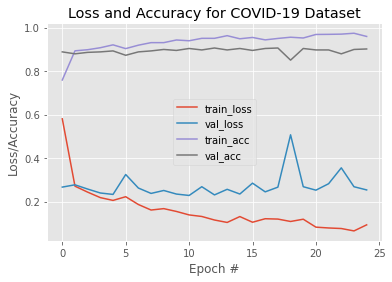

In [ ]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Loss and Accuracy for COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="best")

In [ ]:
# load saved model
loaded_model = load_model("drive/My Drive/Colab Notebooks/checkpoint/segmented_vgg_1225_covid_normal_flow_from_directory.h5")

In [ ]:
loaded_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
# load test data
testImagePaths = list(paths.list_images('drive/My Drive/Colab Notebooks/Segmented_testdata'))
testData = []
testLabels = []

[INFO] loading images...


In [ ]:
# loop over the image paths
for testImagePath in testImagePaths:
	# extract the class label from the filename
	label = testImagePath.split(os.path.sep)[-2]

	# load the image, setup color channels and resize image
	image = cv2.imread(testImagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	testData.append(image)
	testLabels.append(label)

In [ ]:
print(len(testData))
testLabelNames = testLabels.copy()
print(testLabelNames[-5])

50
normal


In [ ]:
# convert the data and labels to NumPy arrays and scaling the pixel intensity to the range [0, 1]
testData = np.array(testData) / 255 
testLabels = np.array(testLabels)

# CHANGE THE TEST IMAGE HERE
x = testData[[-5]]
print(x.shape)
print(x.max())

(1, 224, 224, 3)
0.7176470588235294


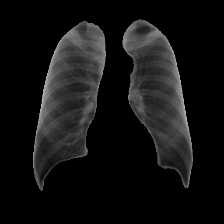

(224, 224, 3)

In [ ]:
testImg = x[0]
cv2_imshow(testImg*255)
testImg.shape

In [ ]:
# generate predictions
preds = loaded_model.predict(testData)

In [ ]:
print(preds)

[[5.56803025e-05]
 [1.42683417e-01]
 [2.67407322e-05]
 [7.73110986e-03]
 [9.84016140e-08]
 [5.49496590e-08]
 [1.02173758e-09]
 [1.61718696e-01]
 [9.63577440e-10]
 [4.88072634e-04]
 [9.26797366e-05]
 [2.12853180e-07]
 [1.81132094e-07]
 [1.32709742e-04]
 [9.63728652e-09]
 [5.20467758e-04]
 [1.11118890e-04]
 [6.49337949e-07]
 [1.10250255e-06]
 [9.99999046e-03]
 [5.32130301e-02]
 [1.54886465e-07]
 [9.98009503e-01]
 [3.33172636e-07]
 [4.57917595e-05]
 [1.07526779e-03]
 [2.63780355e-04]
 [9.99947250e-01]
 [1.77592039e-04]
 [2.51691517e-07]
 [3.63054425e-01]
 [1.86622143e-04]
 [3.68668185e-09]
 [2.46316195e-04]
 [1.06260071e-04]
 [3.95833085e-05]
 [7.02129546e-06]
 [1.68884981e-06]
 [1.81119321e-05]
 [4.04887771e-07]
 [1.82438940e-01]
 [9.86324977e-09]
 [8.75805259e-01]
 [1.28526190e-09]
 [4.90516424e-04]
 [2.42046682e-12]
 [7.35890993e-09]
 [5.48094511e-04]
 [8.74292709e-08]
 [1.30032748e-01]
 [1.88605034e-12]
 [2.53550070e-08]
 [2.78418497e-06]
 [2.80389190e-03]
 [4.66963634e-10]
 [4.326528

In [ ]:
# create heatmaps
with tensorflow.GradientTape() as tape:
  last_conv_layer = loaded_model.get_layer('block5_conv3')
  iterate = keras.models.Model([loaded_model.inputs], [loaded_model.output, last_conv_layer.output])
  model_out, last_conv_layer = iterate(x)
  class_out = model_out[:, np.argmax(model_out[0])]
  grads = tape.gradient(class_out, last_conv_layer)
  pooled_grads = K.mean(grads, axis=(0, 1, 2))
  
heatmap3D = tensorflow.reduce_mean(tensorflow.multiply(pooled_grads, last_conv_layer), axis=-1)

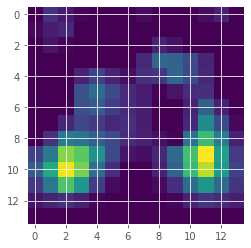

In [ ]:
heatmap = np.maximum(heatmap3D, 0)
heatmap /= np.max(heatmap3D)
heatmap.shape
plt.imshow(heatmap[0])
heatmap1 = heatmap[0]

In [ ]:
testImg = testImg*255
testImg.shape[0]
heatmap = cv2.resize(heatmap1, (testImg.shape[1], testImg.shape[0]))
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)
INTENSITY = 0.5
img = heatmap * INTENSITY + testImg
heatmap.shape

(224, 224, 3)

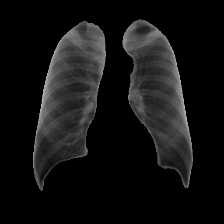

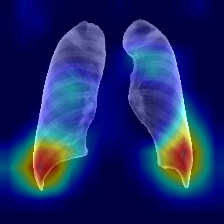

In [ ]:
cv2_imshow(testImg)
cv2_imshow(img)